# Notebook para analise de dados financeiros com Python
Este notebook foi produzido por Cleiton Souza (cleitonsouza01@gmail.com)
## Neste notebook eu apresento uso de técnicas para analise de dados financeiros usando python.
## O resultado final da analise poderá ser usando como entrada de dados para uma analise preditiva de data science usando técnica de redes neurais ou outras




In [1]:
import os
import datetime
from datetime import timedelta

import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.dates import date2num

import talib as ta

import quandl
import pickle

from sklearn.neural_network import MLPRegressor
from sklearn import datasets
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split


%matplotlib inline

Para verificar codigos dos symbols no quandl 
https://www.quandl.com/search?query=

## Seção de funções

In [2]:
########################################
#
# FUNÇOES PARA DOWNLOAD DE DADOS
#
today_date = datetime.datetime.now().strftime('%Y-%m-%d')

def get_data_local(market, tickInterval):
    '''
    Abre arquivo de cache csv em um pandas dataframe quando arquivo estiver disponivel
    '''
    cachefile_with_path = r'bittrex/{}/{}-{}.csv'.format(tickInterval.lower(), market, tickInterval)
    
    try:
        df = pd.DataFrame.from_csv(cachefile_with_path)
        print('Arquivo \'{}\' aberto com sucesso!'.format(cachefile_with_path))
    except ValueError:
        print('ERRO {}'.format(ValueError))
        
    return df


def get_data(symbol, source='quandl', janela='day', start_date='2010-01-01', end_date=today_date):
    '''
    Faz download de dados usando pandas_datareader
    '''
    import pathlib
    if source == 'local':
        return get_data_local(symbol, janela)
    
    file = '{}-{}-{}_{}.pkl'.format(source.upper(), symbol, start_date, end_date).replace('/','-')
    data_dir_name = 'DATA'
    cachefile_with_path = os.path.join(data_dir_name, file)
    
    # Cria diretorio DATA se nao existir      
    if not os.path.isdir(data_dir_name):
        import errno
        try:
            pathlib.Path(data_dir_name).mkdir(parents=True, exist_ok=True)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise
            pass
        
    # Baixa dados recentes se nao existir cache
    try:
        f = open(cachefile_with_path, 'rb')
        df = joblib.load(cachefile_with_path)
        print('Loaded {} from cache {}'.format(symbol, cachefile_with_path))
    except (IOError,OSError):
        print('Downloading {} from {} to {}'.format(symbol, source, cachefile_with_path) )
        df = data.DataReader(symbol, source, start_date, end_date)
        joblib.dump(df, cachefile_with_path)
        print('Cached {} at {}'.format(symbol, cachefile_with_path))
    return df

########################################
#
# FUNÇOES PARA ANALISE TÉCNICA
#
def tech_analisys(OHLCV, indicators, setup):
    open = OHLCV['open']
    high = OHLCV['high']
    low = OHLCV['low']
    close = OHLCV['close']
    volume = OHLCV['volume']

    analysis = pd.DataFrame(index= OHLCV['df_index'])

    #####################
    # Overlap Studies
    if 'bbands_uppper' in indicators:
        BBANDS_PERIOD = setup['BBANDS_PERIOD']
        analysis['bbands_uppper'], analysis['bbands_middle'], analysis['bbands_lower'] = ta.BBANDS(close, timeperiod=BBANDS_PERIOD, nbdevup=2, nbdevdn=2, matype=0)
    
    if 'sma_f' in indicators:
        SMA_FAST = setup['SMA_FAST']
        analysis['sma_f'] = ta.EMA(close, SMA_FAST)
    
    if 'sma_s' in indicators:
        SMA_SLOW = setup['SMA_SLOW']
        analysis['sma_s'] = ta.SMA(close, SMA_SLOW)

    if 'sma_100' in indicators:
        analysis['sma_100'] = ta.SMA(close, 100)

    if 'sma_200' in indicators:
        analysis['sma_200'] = ta.SMA(close, 200)

    if 'tema' in indicators: 
        TEMA_PERIOD = setup['TEMA_PERIOD']  
        analysis['tema'] = ta.TEMA(close, TEMA_PERIOD)
    

    #####################
    # Momentum Indicators
    if 'macd' in indicators: 
        MACD_FAST = setup['MACD_FAST'] 
        MACD_SLOW = setup['MACD_SLOW'] 
        MACD_SIGNAL = setup['MACD_SIGNAL'] 
        analysis['macd'], analysis['macdSignal'], analysis['macdHist'] = ta.MACD(close, fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)


    #####################
    # Volume Indicators


    #####################
    # Volatility Indicators
    if 'std_deviation' in indicators:
        STD_PERIOD = setup['STD_PERIOD'] 
        analysis['std_deviation'] = ta.STDDEV(close, STD_PERIOD, nbdev=1)


    #####################
    # Price Transform
    if 'price_weight' in indicators:
        analysis['price_weight'] = ta.WCLPRICE(high, low, close)


    #####################
    # Pattern Recognition


    #####################
    # Math Transform


    #####################
    # Test indicators
    

    return analysis






## Inicio do download e tratamento dos dados

In [3]:
########################################
#
# CARREGAR DADOS DE ARQUIVO OU WEB
#
# tickInterval must be in [“oneMin”, “fiveMin”, “thirtyMin”, “hour”, “day”].
#
# Exemplo nome de exchanges: 'BCHARTS/MRCDBRL' , 'BCHARTS/FOXBITBRL'
today_date = datetime.datetime.now().strftime('%Y-%m-%d')

exchange='BCHARTS/MRCDBRL'
janela = 'day'
BTCUSD_COMPARE = True


#df = get_data_local('USDT-BTC', janela)
df = get_data(exchange, 'quandl', janela)
if BTCUSD_COMPARE: df_BTC = get_data('BCHARTS/BITSTAMPUSD', 'quandl', janela)

print('\n\nTamanho df: {}'.format( len(df.index) ))

if BTCUSD_COMPARE:  print('Tamanho df_BTC: {}'.format( len(df_BTC.index) ))



Loaded BCHARTS/MRCDBRL from cache DATA/QUANDL-BCHARTS-MRCDBRL-2010-01-01_2018-10-15.pkl
Loaded BCHARTS/BITSTAMPUSD from cache DATA/QUANDL-BCHARTS-BITSTAMPUSD-2010-01-01_2018-10-15.pkl


Tamanho df: 2636
Tamanho df_BTC: 2589


In [4]:
########################################
#
# MOSTRANDO DADOS BAIXADO JÁ DENTRO DE UM PANDAS DATAFRAME
#
df.head()

,Open,High,Low,Close,VolumeBTC,VolumeCurrency,WeightedPrice
Date,,,,,,,
2018-10-14,24089.97999,24095.00000,23536.90001,24000.00,39.260772,9.334726e+05,23776.217392
2018-10-13,23885.00001,24124.00000,23700.00000,24089.98,19.031781,4.560238e+05,23961.172252
2018-10-12,23815.00001,24190.00000,23710.00000,24062.76,47.993285,1.150808e+06,23978.525945
2018-10-11,25141.00000,25280.00000,23623.33000,23815.00,331.379948,8.005652e+06,24158.530237
2018-10-10,25231.50001,25599.99999,24900.00000,25280.00,145.579956,3.658375e+06,25129.662024


In [5]:
########################################
#
# EXEMPLO DE UM "SELECT" POR INTERVALO EM UM PANDAS DATAFRAME
#

pd.options.display.max_rows = 500
df.loc[pd.date_range(start='2011-09-01', end='2011-12-01')]

,Open,High,Low,Close,VolumeBTC,VolumeCurrency,WeightedPrice
2011-09-01,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
2011-09-02,17.99000,18.00000,17.99000,18.00000,9.999500,179.971000,17.998000
2011-09-03,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
2011-09-04,10.00000,18.49000,10.00000,14.00000,5.631330,85.568920,15.195153
2011-09-05,12.00000,12.00000,12.00000,12.00000,0.780000,9.360000,12.000000
2011-09-06,12.50000,14.00000,12.50000,14.00000,0.220000,3.000000,13.636364
2011-09-07,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
2011-09-08,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000
2011-09-09,12.00000,14.00000,9.00000,9.00000,27.420000,267.811000,9.766995
2011-09-10,13.00000,13.00000,13.00000,13.00000,0.050000,0.650000,13.000000


In [6]:
########################################
#
# CORTANDO PARTE DO PANDAS DATAFRAME
#
df = df.loc[pd.date_range(start='2014-01-01', end=today_date)]
df.head()


/home/magic/workspace/python/analisys/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


,Open,High,Low,Close,VolumeBTC,VolumeCurrency,WeightedPrice
2014-01-01,1848.00000,1890.00000,1841.00,1841.10001,20.161476,37598.984710,1864.892432
2014-01-02,1870.00000,1950.00000,1841.02,1950.00000,48.004747,91095.302187,1897.631111
2014-01-03,1945.00000,2107.99999,1889.00,2103.98999,51.870842,106500.374293,2053.183826
2014-01-04,2103.98999,2198.99998,1990.00,2145.00000,41.233653,86605.831022,2100.367671
2014-01-05,2145.00000,2300.00000,2100.00,2225.00068,27.681660,61500.276185,2221.697542


In [7]:
########################################
#
# CONVERSAO NECESSARIO PARA DADOS DA VINDO DO QUANDL
#
#
df.rename(columns={'VolumeBTC': 'Volume', 'VolumeCurrency': 'Base_Volume'}, inplace=True)
df = df.sort_index()
df.head()

,Open,High,Low,Close,Volume,Base_Volume,WeightedPrice
2014-01-01,1848.00000,1890.00000,1841.00,1841.10001,20.161476,37598.984710,1864.892432
2014-01-02,1870.00000,1950.00000,1841.02,1950.00000,48.004747,91095.302187,1897.631111
2014-01-03,1945.00000,2107.99999,1889.00,2103.98999,51.870842,106500.374293,2053.183826
2014-01-04,2103.98999,2198.99998,1990.00,2145.00000,41.233653,86605.831022,2100.367671
2014-01-05,2145.00000,2300.00000,2100.00,2225.00068,27.681660,61500.276185,2221.697542


In [8]:
########################################
#
# CONVERSAO NECESSARIO PARA DADOS DA VINDO DO QUANDL PARA O SEGUNDO DATAFRAME
#
#
if BTCUSD_COMPARE: 
    df_BTC.rename(columns={'VolumeBTC': 'Volume', 'VolumeCurrency': 'Base_Volume'}, inplace=True)
    df_BTC = df_BTC.sort_index()
    print(df_BTC.head())

            Open  High   Low  Close     Volume  Base_Volume  WeightedPrice
Date                                                                      
2011-09-13  5.80  6.00  5.65   5.97  58.371382   346.097389       5.929231
2011-09-14  5.58  5.72  5.52   5.53  61.145984   341.854813       5.590798
2011-09-15  5.12  5.24  5.00   5.13  80.140795   408.259002       5.094272
2011-09-16  4.82  4.87  4.80   4.85  39.914007   193.763147       4.854515
2011-09-17  4.87  4.87  4.87   4.87   0.300000     1.461000       4.870000


In [9]:
########################################
#
# LIMPEZA DOS DADOS
#

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

def clean_dataset_Close(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    global dates_to_drop
    df['Close'].replace(0.0, np.nan, inplace=True)
    dates_to_drop = df.loc[df['Close'].isin([np.nan, np.inf, -np.inf])].index
    df.dropna(inplace=True)
    return df
    

print('Tamanho df original: {} '.format( len(df.index) ) )
df = clean_dataset(df)
df = clean_dataset_Close(df)
print('Tamanho df limpo: {} '.format( len(df.index) ) )

if BTCUSD_COMPARE: 
    print('Tamanho df_BTC original: {} '.format( len(df_BTC.index) ) )
    df_BTC = df_BTC.loc[df.first_valid_index():df.last_valid_index()]
    df_BTC = df_BTC.loc[df.index]
    df_BTC = clean_dataset(df_BTC)
    df_BTC = clean_dataset_Close(df_BTC)
    print('Tamanho df_BTC limpo: {} '.format( len(df_BTC.index) ) )

print('\nFIRST:')
print('df:     {}'.format(df.first_valid_index()) )
if BTCUSD_COMPARE: print('df_BTC: {}'.format(df_BTC.first_valid_index()) )

print('\nLAST:')
print('df:     {}'.format(df.last_valid_index()) )
if BTCUSD_COMPARE: print('df_BTC: {}'.format(df_BTC.last_valid_index()) )


Tamanho df original: 1749 
Tamanho df limpo: 1748 
Tamanho df_BTC original: 2589 
Tamanho df_BTC limpo: 1745 

FIRST:
df:     2014-01-01 00:00:00
df_BTC: 2014-01-01 00:00:00

LAST:
df:     2018-10-14 00:00:00
df_BTC: 2018-10-14 00:00:00


In [10]:
########################################
#
# ANALISE TECNICA - Prepara dados
#

OHLCV = {'open': df.Open.values, \
        'high': df.High.values, \
        'low': df.Low.values, \
        'close': df.Close.values, \
        'volume': df.Volume.values, \
        'df_index': df.index, }

indicators = ['bbands_uppper', 'bbands_middle', 'bbands_lower', 'sma_f', 'sma_s', \
               'sma_100', 'sma_200', 'macd', 'macdSignal', 'macdHist', 'std_deviation', \
               'price_weight']

setup = {'SMA_FAST': 9, 'SMA_SLOW': 42, 'RSI_PERIOD': 14, 'RSI_AVG_PERIOD': 13,
        'MACD_FAST': 8, 'MACD_SLOW': 21, 'MACD_SIGNAL': 11, 'STOCH_K': 14, 'STOCH_D': 3, 'SIGNAL_TOL': 3, \
        'Y_AXIS_SIZE': 12, 'ADX_PERIOD': 8, 'MOM_PERIOD': 11, 'WILL_PERIOD': 11, \
        'STD_PERIOD': 5, 'BBANDS_PERIOD': 8, 'DI_PERIOD': 13, 'DM_PERIOD': 13, 'DX_PERIOD': 13, \
        'ATR_PERIOD': 13, 'BETA_PERIOD': 5, 'TEMA_PERIOD': 13}


In [11]:
########################################
#
# ANALISE TECNICA - Executa calculo
#

analysis = tech_analisys(OHLCV, indicators, setup)

analysis.tail()

,bbands_uppper,bbands_middle,bbands_lower,sma_f,sma_s,sma_100,sma_200,macd,macdSignal,macdHist,std_deviation,price_weight
2018-10-10,26235.781368,25688.473745,25141.166122,25786.521435,27147.356911,27093.178896,27635.810990,-564.429840,-398.904142,-165.525698,250.864575,25264.999997
2018-10-11,26780.654580,25439.348763,24098.042945,25392.217148,27028.309292,27074.328896,27610.047388,-764.205618,-459.787721,-304.417897,690.394351,24133.332500
2018-10-12,26774.202545,25211.811263,23649.419980,25126.325718,26909.803815,27054.956496,27589.861138,-857.488580,-526.071198,-331.417382,735.361226,24006.380000
2018-10-13,26536.456154,24965.531250,23394.606346,24919.056575,26790.493768,27036.476296,27575.311038,-902.548884,-588.817479,-313.731406,628.000999,24000.990000
2018-10-14,26250.440877,24731.780000,23213.119123,24735.245260,26666.708768,27017.476296,27560.311038,-927.991951,-645.346558,-282.645393,524.078085,23907.975002


## Plotando gráfico de alguns indicadores calculados

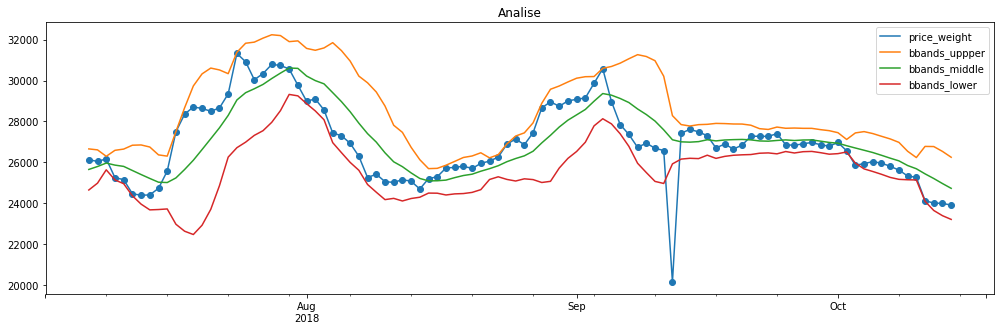

In [12]:
#analysis['sma_f'].tail(100).plot(figsize=(17,4), marker='o', title='Analise', legend=True)
#analysis['sma_s'].tail(100).plot(figsize=(17,4), marker='o', title='Analise', legend=True)
analysis['price_weight'].tail(100).plot(figsize=(17,5), marker='o', title='Analise', legend=True)

analysis['bbands_uppper'].tail(100).plot(figsize=(17,5), marker='', title='Analise', legend=True)
analysis['bbands_middle'].tail(100).plot(figsize=(17,5), marker='', title='Analise', legend=True)
analysis['bbands_lower'].tail(100).plot(figsize=(17,5), marker='', title='Analise', legend=True)



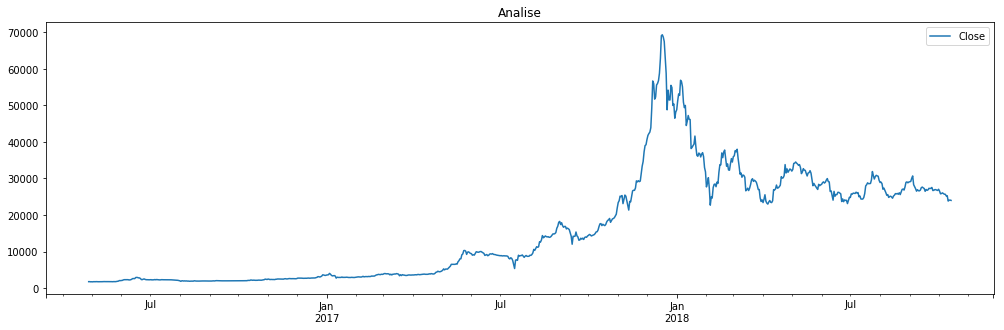

In [13]:
df['Close'].tail(900).plot(figsize=(17,5), marker='', title='Analise', legend=True)

# Inicio da analise baseado em data science

In [14]:
########################################
#
# ANALISE TECNICA - Adicionando mais dados como previsores
#
#

analysis['Main_Price'] = df['Close']
analysis['Main_Volume'] = df['Volume']
analysis['Main_Base_Volume'] = df['Base_Volume']

classe = df

if BTCUSD_COMPARE: 
    analysis['BTC_Price'] = df_BTC['Close']
    analysis['BTC_VOL'] = df_BTC['Volume']
    analysis['BTC_Base_Volume'] = df_BTC['Base_Volume']


In [15]:
########################################
#
# LIMPEZA E FORMATACAO DOS DATAFRAMES
#
#

# https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe
tamanho_antes = len(analysis.index)

analysis = clean_dataset(analysis)

start_date = analysis.first_valid_index()
end_date = analysis.last_valid_index()

classe = df.loc[start_date:end_date]
classe = classe.loc[analysis.index]

classe = classe['Close']

print('{} {} {}'.format(len(analysis), len(df_BTC), len(classe)) )
print('Antes: {}\nDepois: {}\nDiferenca: {}'.format(tamanho_antes, len(analysis.index), (tamanho_antes-len(analysis.index))))
print('Quantidade de previsores: {}'.format(len(analysis.columns)))

1546 1745 1546
Antes: 1748
Depois: 1546
Diferenca: 202
Quantidade de previsores: 18


In [16]:
########################################
#
# DESCOLANDO CLASSE PARA PREVER FUTURO
#
#
print(classe.tail())
classe = classe.shift(-1)

# Despois de deslocamente necessario prencher
# celulas NaN. preenchido com ultimos dados
classe = classe.fillna(method='ffill')

print('\n\n')
print(classe.tail())

2018-10-10    25280.00
2018-10-11    23815.00
2018-10-12    24062.76
2018-10-13    24089.98
2018-10-14    24000.00
Name: Close, dtype: float64



2018-10-10    23815.00
2018-10-11    24062.76
2018-10-12    24089.98
2018-10-13    24000.00
2018-10-14    24000.00
Name: Close, dtype: float64


In [17]:
########################################
#
# NORMALIZAÇÃO DOS DADOS
#
# StandardScaler faz o escalonamento dos numeros, deixa todos numeros na mesma
# escala para que o algoritmo nao priorize mais um ou outro
#
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
previsores = scaler.fit_transform(analysis)


In [18]:
previsores

array([[-0.60756717, -0.61601741, -0.62285905, ..., -0.56287423,
        -0.96366627, -0.5136403 ],
       [-0.60631591, -0.61536379, -0.62296313, ..., -0.56331505,
        -1.01060887, -0.51822825],
       [-0.60623527, -0.61474789, -0.62167606, ..., -0.56446983,
        -0.7540652 , -0.49418943],
       ...,
       [ 1.1003403 ,  1.18085926,  1.27508506, ...,  0.93983787,
        -0.82749265, -0.218201  ],
       [ 1.08423281,  1.16219611,  1.25331467, ...,  0.94377009,
        -0.96053108, -0.34333315],
       [ 1.06485507,  1.14448238,  1.23780902, ...,  0.944146  ,
        -0.92177885, -0.30523009]])

In [19]:
#########################################
#
# DIVIDE DADOS ENTRE PREVISORES E CLASSE
#
def base_divide(previsores, classe, test_size, random_state):
    '''
    Divisão da base entre treinamento e test 'train and test'
    '''
        
    return train_test_split(previsores, classe, test_size=test_size, random_state=random_state)

In [20]:
#########################################
#
# CARREGAR REDE NEURAL APRENDIDA
#
random_test_size = 0.29
random_number = 982
previsores_treinamento, previsores_teste, classe_treinamento, classe_teste = base_divide(previsores, 
                                                                                     classe, random_test_size,
                                                                                             random_number)
print('classe treinamento size: {}'.format(len(classe_treinamento)))
print('classe teste size: {}'.format(len(classe_teste)))


classe treinamento size: 1097
classe teste size: 449


## Com os previsores devidamente normalizados, usamos eles como entrada da rede neural onde objetemos a previsão 
